In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time
import pickle

from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import classification_report, accuracy_score

from utils.subspace_clustering_helper_funcs import *
from utils.ae_eval_and_vis import *
from utils.ae_torch_classes import *
from utils.ml_pipeline import *
from utils.preprocessing import *

# Load in Data

In [2]:
# Kai's laptop
#data_path = "C:\\Users\\kdmen\\Desktop\\Research\\Data\\$M\\PCA_40D\\"
#full_data_path = "C:\\Users\\kdmen\\Desktop\\Research\\Data\\$M\\Filtered_Datasets\\"
#model_dir_path = 'C:\\Users\\kdmen\\Desktop\\Research\\Repos\\fl-gestures\\models\\Embedding\\Autoencoders\\'

# BRC Desktop
full_data_path = "D:\\Kai_MetaGestureClustering_24\\saved_datasets\\Filtered_Datasets\\"
embedding_data_path = "D:\\Kai_MetaGestureClustering_24\\saved_datasets\\Autoencoders\\EMG_Only\\"
model_dir_path = 'C:\\Users\\YamagamiLab\\Desktop\\Dev\\fl-gestures\\models\\Embedding\\Autoencoders\\'


In [3]:
metadata_cols = ['Participant', 'Gesture_ID', 'Gesture_Num']

In [4]:
# Save the state dictionary
#torch.save(model.state_dict(), 'gesture_lstm_model.pth')
# Load the state dictionary
#loaded_model = GestureLSTMClassifier(input_size, hidden_size, num_layers, num_classes)
#loaded_model.load_state_dict(torch.load('gesture_lstm_model.pth'))

## EMG Only AE Embeddings

In [5]:
with open(embedding_data_path+'RNNAE_20_10mir_EMGOnly_latent_representations.pkl', 'rb') as file:
    loaded_latent_representations = pickle.load(file)

In [6]:
loaded_latent_representations.shape

(1557, 64, 10)

I only saved the test data representations... I need the training data to train the classification model

In [7]:
print("Loading")
metadata_cols = ['Participant', 'Gesture_ID', 'Gesture_Num']
full_emg_XY_df = pd.read_pickle(full_data_path+'metadata_EMG_allgestures_allusers.pkl')

Loading


In [8]:
print(full_emg_XY_df.shape)
full_emg_XY_df.head()

(427008, 19)


,Participant,Gesture_ID,Gesture_Num,EMG1,EMG2,EMG3,EMG4,EMG5,EMG6,EMG7,EMG8,EMG9,EMG10,EMG11,EMG12,EMG13,EMG14,EMG15,EMG16
0,P102,pan,1,0.000002,0.000002,0.000001,0.000002,0.000003,0.000004,0.000002,0.000002,0.000003,0.000020,0.000004,0.000004,0.000002,0.000009,0.000001,0.000002
1,P102,pan,1,0.000002,0.000002,0.000001,0.000002,0.000003,0.000005,0.000003,0.000003,0.000003,0.000014,0.000007,0.000007,0.000002,0.000017,0.000001,0.000002
2,P102,pan,1,0.000002,0.000002,0.000001,0.000002,0.000004,0.000005,0.000003,0.000003,0.000004,0.000007,0.000004,0.000005,0.000003,0.000020,0.000003,0.000002
3,P102,pan,1,0.000002,0.000002,0.000002,0.000002,0.000005,0.000006,0.000003,0.000003,0.000006,0.000005,0.000004,0.000003,0.000004,0.000015,0.000003,0.000003
4,P102,pan,1,0.000003,0.000002,0.000002,0.000002,0.000005,0.000007,0.000003,0.000002,0.000008,0.000003,0.000007,0.000022,0.000004,0.000017,0.000002,0.000003


In [9]:
print("Started")
start_time = time.time()

preprocessing_approach = 'StandardScaler'
full_emg_ppd_XY_df = preprocess_df_by_gesture(full_emg_XY_df, preprocessing_approach)

print(f"Completed in {time.time() - start_time}s")

print(full_emg_ppd_XY_df.shape)
full_emg_ppd_XY_df.head()

Started
Completed in 16.231783628463745s
(427008, 19)


,Participant,Gesture_ID,Gesture_Num,EMG1,EMG2,EMG3,EMG4,EMG5,EMG6,EMG7,EMG8,EMG9,EMG10,EMG11,EMG12,EMG13,EMG14,EMG15,EMG16
0,P102,pan,1,-0.987911,-1.165988,-1.097816,-1.324972,-0.804709,-0.801495,-0.925569,-0.480126,-1.847291,-0.286930,-1.191791,-0.800271,-2.597721,-2.790928,-1.370371,-1.068966
1,P102,pan,1,-0.957434,-1.127710,-1.096292,-1.050030,-0.523045,-0.509405,-0.421499,1.610438,-1.725413,-0.576721,-0.012891,-0.155093,-1.902118,-0.331839,-1.198487,-0.442703
2,P102,pan,1,-1.037155,-1.109171,-1.141693,-0.579458,0.069465,-0.354913,-0.229309,2.102434,-1.412565,-0.942372,-1.079161,-0.531992,-1.553927,0.324155,1.214440,0.053655
3,P102,pan,1,-0.998947,-1.113353,-1.073016,-0.496784,0.725939,0.016008,-0.197335,1.454171,-0.897182,-1.027206,-1.171201,-0.862180,-0.748456,-0.988000,1.570302,2.269483
4,P102,pan,1,-0.668818,-1.107272,-0.871131,-0.555957,0.891696,0.178288,-0.013161,0.745722,-0.034943,-1.128485,-0.262000,2.983983,-0.733148,-0.332348,-0.382037,1.959513


In [10]:
# Held out useres from NB 003
held_out_user_pids = ['P103','P109','P114','P124','P128','P004','P010']

In [11]:
test_users_df = full_emg_ppd_XY_df[full_emg_ppd_XY_df['Participant'].isin(held_out_user_pids)]

print(test_users_df.shape)
test_users_df.head()

(99648, 19)


,Participant,Gesture_ID,Gesture_Num,EMG1,EMG2,EMG3,EMG4,EMG5,EMG6,EMG7,EMG8,EMG9,EMG10,EMG11,EMG12,EMG13,EMG14,EMG15,EMG16
11520,P103,gesture-1,1,-1.176959,-1.080891,-1.389629,-0.764383,-0.909322,-1.184916,-1.166154,-0.285151,-1.197736,-1.366452,-0.579818,-0.301119,-1.028176,-1.511639,0.321498,-0.569058
11521,P103,gesture-1,1,-1.154277,-1.053524,-1.389045,-0.954110,-0.948722,-1.097234,-0.973987,-0.794133,-1.192175,-1.324697,-0.566037,-0.302095,-1.033397,-1.497792,-0.296090,-0.423740
11522,P103,gesture-1,1,-1.159822,-1.053038,-1.449064,-1.055581,-0.927348,-1.054935,-1.445696,-0.674215,-1.196381,-1.321241,-0.560094,-0.296469,-1.041279,-1.506983,-1.186492,-0.338736
11523,P103,gesture-1,1,-1.151158,-1.074787,-1.392106,-0.872960,-0.906804,-0.947973,-0.943491,-1.160571,-1.200982,-1.380560,-0.559997,-0.257878,-1.039429,-1.509064,0.459703,-0.297593
11524,P103,gesture-1,1,-1.147660,-1.102767,-1.468131,-0.814908,-0.937734,-1.008698,-1.066971,-1.016777,-1.197103,-1.385592,-0.546055,-0.265153,-1.023555,-1.513734,0.110801,-0.466502


In [12]:
# Merge the DataFrames with an indicator
merged_df = full_emg_ppd_XY_df.merge(test_users_df, how='left', indicator=True)
# Filter out the rows that are in both DataFrames
training_users_df = merged_df[merged_df['_merge'] == 'left_only'].drop(columns='_merge')

print(training_users_df.shape)
training_users_df.head()

(327360, 19)


,Participant,Gesture_ID,Gesture_Num,EMG1,EMG2,EMG3,EMG4,EMG5,EMG6,EMG7,EMG8,EMG9,EMG10,EMG11,EMG12,EMG13,EMG14,EMG15,EMG16
0,P102,pan,1,-0.987911,-1.165988,-1.097816,-1.324972,-0.804709,-0.801495,-0.925569,-0.480126,-1.847291,-0.286930,-1.191791,-0.800271,-2.597721,-2.790928,-1.370371,-1.068966
1,P102,pan,1,-0.957434,-1.127710,-1.096292,-1.050030,-0.523045,-0.509405,-0.421499,1.610438,-1.725413,-0.576721,-0.012891,-0.155093,-1.902118,-0.331839,-1.198487,-0.442703
2,P102,pan,1,-1.037155,-1.109171,-1.141693,-0.579458,0.069465,-0.354913,-0.229309,2.102434,-1.412565,-0.942372,-1.079161,-0.531992,-1.553927,0.324155,1.214440,0.053655
3,P102,pan,1,-0.998947,-1.113353,-1.073016,-0.496784,0.725939,0.016008,-0.197335,1.454171,-0.897182,-1.027206,-1.171201,-0.862180,-0.748456,-0.988000,1.570302,2.269483
4,P102,pan,1,-0.668818,-1.107272,-0.871131,-0.555957,0.891696,0.178288,-0.013161,0.745722,-0.034943,-1.128485,-0.262000,2.983983,-0.733148,-0.332348,-0.382037,1.959513


In [13]:
emg_gesture_train_labels_df = training_users_df['Gesture_ID']
emg_gesture_test_labels_df = test_users_df['Gesture_ID']
emg_user_train_labels_df = training_users_df['Participant']
emg_user_test_labels_df = test_users_df['Participant']
emg_training_users_df = training_users_df.drop(metadata_cols, axis=1)
emg_test_users_df = test_users_df.drop(metadata_cols, axis=1)

seq_len = 64
num_gestures = emg_training_users_df.shape[0]//seq_len
sample_data = emg_training_users_df.to_numpy().reshape(num_gestures, seq_len, -1)
input_dim = sample_data.shape[-1]
print(sample_data.shape)

(5115, 64, 16)


In [14]:
print(emg_gesture_train_labels_df.shape)
emg_gesture_train_labels_df.head()

(327360,)


0    pan
1    pan
2    pan
3    pan
4    pan
Name: Gesture_ID, dtype: object

In [28]:
gesture_encoder = OneHotEncoder(sparse=False)
labels_reshaped = emg_gesture_train_labels_df.to_numpy().reshape(-1, 1)
labels_encoded = gesture_encoder.fit_transform(labels_reshaped)
encoded_labels_df = pd.DataFrame(labels_encoded, columns=gesture_encoder.categories_[0]).iloc[::seq_len]

print(encoded_labels_df.shape)
encoded_labels_df.head()

(5115, 28)


C:\Users\YamagamiLab\anaconda3\envs\fl_torch_sum24\lib\site-packages\sklearn\preprocessing\_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


,air-tap,close,delete,double-clench,double-pinch,duplicate,frequency,gesture-1,gesture-2,gesture-3,...,point-and-pinch,range-of-motion,rotate,select-single,shake-and-release,single-clench,single-pinch,two-handed-tap,zoom-in,zoom-out
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
64,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
128,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
192,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
256,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [27]:
gesture_encoder = OneHotEncoder(sparse=False)
test_labels_encoded = gesture_encoder.fit_transform(emg_gesture_test_labels_df.to_numpy().reshape(-1, 1))
encoded_test_labels_df = pd.DataFrame(test_labels_encoded, columns=gesture_encoder.categories_[0]).iloc[::seq_len]

print(encoded_test_labels_df.shape)
encoded_test_labels_df.head()

(1557, 28)


C:\Users\YamagamiLab\anaconda3\envs\fl_torch_sum24\lib\site-packages\sklearn\preprocessing\_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


,air-tap,close,delete,double-clench,double-pinch,duplicate,frequency,gesture-1,gesture-2,gesture-3,...,point-and-pinch,range-of-motion,rotate,select-single,shake-and-release,single-clench,single-pinch,two-handed-tap,zoom-in,zoom-out
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
64,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
128,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
192,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
256,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


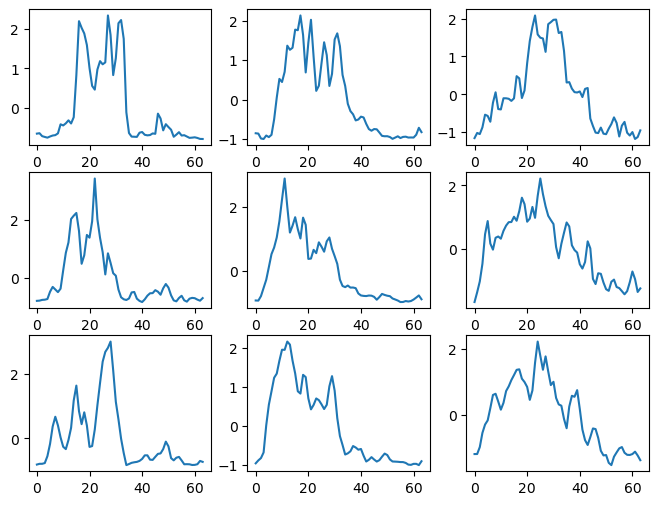

In [17]:
selected_gestures = [1,2,3]
selected_channels = [1,2,3]
fig, axes = plt.subplots(len(selected_gestures), len(selected_channels), figsize=(8,6))
for i, gesture in enumerate(selected_gestures):
    for j, channel in enumerate(selected_channels):
        original = sample_data[gesture, :, channel]
        axes[i, j].plot(original)


In [18]:
print("Started")
num_layers = None
lr = 0.001 # Not passed in rn
hidden_dim_lst = [20, 10]

model_20_10mir = RNNAutoencoder(input_dim, hidden_dim_lst, num_layers, seq_len, mirror=True)
criterion = nn.MSELoss()
optimizer = optim.Adam(model_20_10mir.parameters(), lr=lr)


Started


In [19]:
# Get list of all the unique gesture names
all_train_test_gestures_df = pd.concat([emg_gesture_train_labels_df, emg_gesture_test_labels_df], axis=0)
unique_gestures = all_train_test_gestures_df.unique()

In [20]:
X_3DTensor = torch.tensor(emg_training_users_df.to_numpy().reshape(-1, seq_len, input_dim), dtype=torch.float32)
Xtest_3DTensor = torch.tensor(emg_test_users_df.to_numpy().reshape(-1, seq_len, input_dim), dtype=torch.float32)

print(X_3DTensor.shape)
print(Xtest_3DTensor.shape)

X_train_embeddings = model_20_10mir.encode(X_3DTensor)
X_test_embeddings = model_20_10mir.encode(Xtest_3DTensor)

print(f"encoded_labels_df shape: {encoded_labels_df.shape}")
print(f"encoded_test_labels_df shape: {encoded_test_labels_df.shape}")
print(f"X_train_embeddings shape: {X_train_embeddings.shape}")
print(f"X_test_embeddings shape: {X_test_embeddings.shape}")

torch.Size([5115, 64, 16])
torch.Size([1557, 64, 16])
encoded_labels_df shape: (327360, 28)
encoded_test_labels_df shape: (99648, 28)
X_train_embeddings shape: torch.Size([5115, 64, 10])
X_test_embeddings shape: torch.Size([1557, 64, 10])


In [29]:
y_integer = np.argmax(encoded_labels_df, axis=1)
print(len(y_integer))

ytest_integer = np.argmax(encoded_test_labels_df, axis=1)
print(len(ytest_integer))

5115
1557


In [30]:
batch_size = 32

training_dataset = GestureDatasetClustering(X_train_embeddings, y_integer)
nn_train_loader = DataLoader(training_dataset, batch_size=batch_size, shuffle=True, drop_last=True)

testing_dataset = GestureDatasetClustering(X_test_embeddings, ytest_integer)
nn_test_loader = DataLoader(testing_dataset, batch_size=batch_size, shuffle=False, drop_last=True)

In [31]:
# Model parameters
input_size = X_train_embeddings.shape[-1]
hidden_size = 128  # Number of features in the hidden state
num_layers = 2  # Number of recurrent layers
num_classes = len(unique_gestures)
num_epochs = 15
lr = 0.001

# Loss and optimizer
model = GestureLSTMClassifier_Hidden(input_size, hidden_size, num_layers, num_classes)

print(model)

GestureLSTMClassifier_Hidden(
  (lstm): LSTM(10, 128, num_layers=2, batch_first=True)
  (fc): Linear(in_features=128, out_features=28, bias=True)
)


In [32]:
model_rawEMG, cls_report_rawEMG, labels_lst_rawEMG = train_LSTM_gesture_classifier(model, nn_train_loader, nn_test_loader, lr=lr, num_epochs=num_epochs, batch_size=32, use_hidden=True)

Starting training!
Epoch [1/15], Train Loss: 3.2156, Train Accuracy: 4.95%, Val Loss: 3.2021, Val Accuracy: 3.45%
Epoch [2/15], Train Loss: 3.1624, Train Accuracy: 5.84%, Val Loss: 3.1901, Val Accuracy: 5.14%
Epoch [3/15], Train Loss: 3.1285, Train Accuracy: 6.74%, Val Loss: 3.1742, Val Accuracy: 6.12%
Epoch [4/15], Train Loss: 3.0892, Train Accuracy: 7.82%, Val Loss: 3.1772, Val Accuracy: 6.38%
Epoch [5/15], Train Loss: 3.0423, Train Accuracy: 10.12%, Val Loss: 3.1751, Val Accuracy: 7.03%
Epoch [6/15], Train Loss: 2.9884, Train Accuracy: 11.77%, Val Loss: 3.1522, Val Accuracy: 6.90%
Epoch [7/15], Train Loss: 2.9297, Train Accuracy: 13.01%, Val Loss: 3.1585, Val Accuracy: 8.07%
Epoch [8/15], Train Loss: 2.8711, Train Accuracy: 14.84%, Val Loss: 3.1865, Val Accuracy: 7.36%


KeyboardInterrupt: 